# A Jupyter Notebook for Implementing Neural Collaborative Filtering with the MovieLens Dataset
This notebook demonstrates the implementation of Neural Collaborative Filtering (NeuMF) using the MovieLens dataset. The focus is on optimizing training efficiency and generating personalized movie recommendations.

## Import Required Libraries
Import libraries such as pandas, numpy, PyTorch, scikit-learn, and matplotlib.

In [1]:
# Import Required Libraries
!pip install pandas numpy torch scikit-learn matplotlib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

####  Download and Extract Dataset
# Automated download to ensure correct directory structure

In [2]:
import os
import zipfile
import urllib.request

# Download MovieLens small dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
zip_path = 'ml-latest-small.zip'

if not os.path.exists(zip_path):
    print('Downloading dataset...')
    urllib.request.urlretrieve(url, zip_path)
    print('Download complete')

# Extract with proper nesting
if not os.path.exists('ml-latest-small/ml-latest-small'):
    print('Extracting files...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print('Extraction complete')
else:
    print('Dataset already extracted')

Extracting files...
Extraction complete


## Dataset Preparation with Intelligent Filtering
Load the MovieLens dataset and filter users and items with sufficient interactions. Convert ratings to implicit feedback.

In [3]:
# Load data with aggressive filtering
def load_filtered_data(min_ratings=20):
    df = pd.read_csv('ml-latest-small/ratings.csv')

    
    # Filter users and items with sufficient interactions
    user_counts = df['userId'].value_counts()
    item_counts = df['movieId'].value_counts()
    
    filtered_users = user_counts[user_counts >= min_ratings].index
    filtered_items = item_counts[item_counts >= min_ratings].index
    
    df = df[df['userId'].isin(filtered_users)]
    df = df[df['movieId'].isin(filtered_items)]
    
    # Convert to implicit feedback
    df['rating'] = 1  # Binary implicit feedback
    
    return df

df = load_filtered_data(min_ratings=5)  # Aggressive filtering for speed
print(f"Filtered dataset size: {len(df)} interactions")

Filtered dataset size: 90274 interactions


## Dataset Preprocessing
Map user and movie IDs to unique indices, split the dataset into train and test sets, and generate negative samples.

In [4]:
# Unique entities after filtering
users = df['userId'].unique()
movies = df['movieId'].unique()

# Create mappings
user2id = {u:i for i,u in enumerate(users)}
movie2id = {m:i for i,m in enumerate(movies)}

# Convert IDs
df['user_id'] = df['userId'].map(user2id)
df['movie_id'] = df['movieId'].map(movie2id)

# Train-test split with negative sampling
train, test = train_test_split(df[['user_id', 'movie_id']], 
                              test_size=0.2,
                              stratify=df['user_id'],
                              random_state=42)

# Generate negative samples (1:4 ratio)
def generate_negatives(data, num_negatives=4):
    negatives = []
    for user in data['user_id'].unique():
        pos_movies = set(data[data['user_id'] == user]['movie_id'])
        all_movies = set(movie2id.values())
        neg_movies = list(all_movies - pos_movies)[:num_negatives*len(pos_movies)]
        negatives.extend([(user, m) for m in neg_movies])
    return pd.DataFrame(negatives, columns=['user_id', 'movie_id'])

train_neg = generate_negatives(train)
train_data = pd.concat([train.assign(label=1), 
                       train_neg.assign(label=0)])

# Filter test set to only include users/items from training data
test = test[test['user_id'].isin(train['user_id'])]
test = test[test['movie_id'].isin(train['movie_id'])]

# Generate 99 negatives PER TEST USER
test_neg = []
for user in test['user_id'].unique():
    pos_movies = set(test[test['user_id'] == user]['movie_id'])
    all_movies = set(movie2id.values())
    neg_movies = np.random.choice(
        list(all_movies - pos_movies), 
        99,  # 1:99 negative ratio
        replace=False
    )
    test_neg.extend([(user, m) for m in neg_movies])

test_neg = pd.DataFrame(test_neg, columns=['user_id', 'movie_id'])
test_data = pd.concat([test.assign(label=1), 
                      test_neg.assign(label=0)])


## PyTorch Dataset Class
Define a custom PyTorch Dataset class for efficient data loading.

In [5]:
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.users = torch.LongTensor(data['user_id'].values)
        self.movies = torch.LongTensor(data['movie_id'].values)
        self.labels = torch.FloatTensor(data['label'].values)
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'movie': self.movies[idx],
            'label': self.labels[idx]
        }

# Create dataloaders with reduced batch size
BATCH_SIZE = 512  # Increased batch size for faster training
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## NeuMF Model Implementation
Implement the NeuMF model with GMF and MLP pathways, and a prediction layer.

In [6]:
class NeuMF(nn.Module):
    # def __init__(self, num_users, num_items, factors=8, layers=[16,8]):
    #     super().__init__()
    #     self.num_users = num_users
    #     self.num_items = num_items
        
    #     # GMF components
    #     self.gmf_user = nn.Embedding(num_users, factors)
    #     self.gmf_item = nn.Embedding(num_items, factors)
        
    #     # MLP components
    #     self.mlp_user = nn.Embedding(num_users, factors)
    #     self.mlp_item = nn.Embedding(num_items, factors)
        
    #     self.mlp = nn.Sequential(
    #         nn.Linear(2*factors, layers[0]),
    #         nn.ReLU(),
    #         nn.Linear(layers[0], layers[1]),
    #         nn.ReLU()
    #     )
        
    #     # Prediction layer
    #     self.prediction = nn.Linear(factors + layers[1], 1)
        
    # def forward(self, user, item):
    #     # GMF pathway
    #     gmf_u = self.gmf_user(user)
    #     gmf_i = self.gmf_item(item)
    #     gmf = gmf_u * gmf_i
        
    #     # MLP pathway
    #     mlp_u = self.mlp_user(user)
    #     mlp_i = self.mlp_item(item)
    #     mlp = torch.cat([mlp_u, mlp_i], dim=-1)
    #     mlp = self.mlp(mlp)
        
    #     # Concatenate and predict
    #     concat = torch.cat([gmf, mlp], dim=-1)
    #     return torch.sigmoid(self.prediction(concat).squeeze())
    
    def __init__(self, num_users, num_items, gmf_factors=8, mlp_factors=8, mlp_layers=[32,16,8]):
        super().__init__()
        
        # GMF components
        self.gmf_user = nn.Embedding(num_users, gmf_factors)
        self.gmf_item = nn.Embedding(num_items, gmf_factors)
        
        # MLP components
        self.mlp_user = nn.Embedding(num_users, mlp_factors)
        self.mlp_item = nn.Embedding(num_items, mlp_factors)
        
        self.mlp = nn.Sequential(
            nn.Linear(2*mlp_factors, mlp_layers[0]),
            nn.ReLU(),
            nn.Linear(mlp_layers[0], mlp_layers[1]),
            nn.ReLU(),
            nn.Linear(mlp_layers[1], mlp_layers[2]),
            nn.ReLU()
        )
        
        # Final prediction layer
        self.prediction = nn.Linear(gmf_factors + mlp_layers[-1], 1)

    def forward(self, user, item):
        gmf = self.gmf_user(user) * self.gmf_item(item)
        
        mlp_out = torch.cat([self.mlp_user(user), self.mlp_item(item)], dim=-1)
        mlp_out = self.mlp(mlp_out)
        
        concat = torch.cat([gmf, mlp_out], dim=-1)
        return torch.sigmoid(self.prediction(concat).squeeze())

# Initialize model with reduced dimensions
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = NeuMF(
    num_users=len(users),
    num_items=len(movies),
    gmf_factors=32,
    mlp_factors=32,
    mlp_layers=[64, 32, 16]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

## Training Loop with Early Stopping
Train the model using a training loop with early stopping based on validation loss.

In [7]:
def train_model(model, train_loader, test_loader, epochs=20, patience=5):
    best_loss = float('inf')
    no_improve = 0
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            user = batch['user'].to(device)
            movie = batch['movie'].to(device)
            label = batch['label'].to(device)
            
            pred = model(user, movie)
            loss = criterion(pred, label)
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                user = batch['user'].to(device)
                movie = batch['movie'].to(device)
                label = batch['label'].to(device)
                
                pred = model(user, movie)
                test_loss += criterion(pred, label).item()
                
        train_loss = epoch_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    return train_losses, test_losses

# Train with reduced epochs
train_loss, test_loss = train_model(model, train_loader, test_loader, epochs=25)

Epoch 1: Train Loss: 0.5021, Test Loss: 0.5394
Epoch 2: Train Loss: 0.4516, Test Loss: 0.5927
Epoch 3: Train Loss: 0.4264, Test Loss: 0.7709
Epoch 4: Train Loss: 0.4014, Test Loss: 1.5550
Epoch 5: Train Loss: 0.3809, Test Loss: 2.5761
Epoch 6: Train Loss: 0.3647, Test Loss: 4.0459
Early stopping at epoch 6


## Evaluation Metrics
Evaluate the model using ranking metrics such as Hit Rate @k.

In [8]:
def evaluate(model, test_loader, k=10):
    model.eval()
    hits = 0
    total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            user = batch['user'].to(device)
            movie = batch['movie'].to(device)
            label = batch['label'].to(device)
            
            pred = model(user, movie)
            _, topk = torch.topk(pred, k)
            
            # Get actual positive items
            positive = torch.where(label == 1)[0]
            hits += sum(1 for idx in topk if idx in positive)
            total += len(positive)
            
    return hits / total

hit_rate = evaluate(model, test_loader)
print(f'Hit Rate @10: {hit_rate:.4f}')

Hit Rate @10: 0.0196


## Visualization of Training Progress
Plot training and validation loss over epochs to visualize training progress.

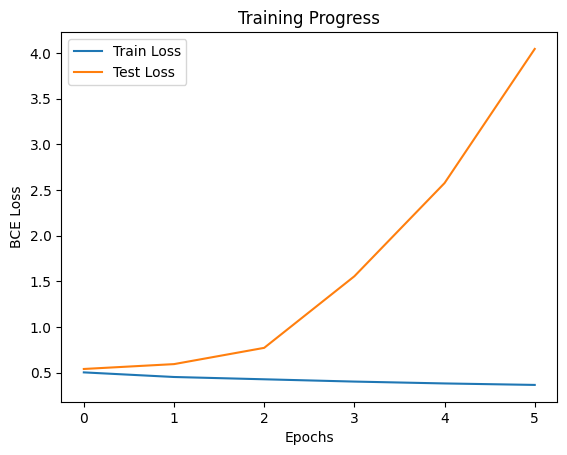

In [9]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.show()

## Generating Recommendations
Define a function to generate top-k movie recommendations for a given user.

In [10]:
def recommend(user_id, top_k=5):
    user_idx = user2id[user_id]
    all_movies = torch.LongTensor(list(movie2id.values())).to(device)
    user_tensor = torch.LongTensor([user_idx]*len(all_movies)).to(device)
    
    with torch.no_grad():
        scores = model(user_tensor, all_movies)
    
    top_indices = scores.argsort(descending=True)[:top_k]
    return [list(movie2id.keys())[idx] for idx in top_indices.cpu().numpy()]

# Example usage
sample_user = df['userId'].iloc[0]
print(f"Recommendations for user {sample_user}:")
print(recommend(sample_user))

Recommendations for user 1:
[np.int64(2797), np.int64(1214), np.int64(919), np.int64(91128), np.int64(1197)]
